In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

## Data Preparation

In [ ]:
# Importing the data
data = pd.read_csv("Global+Superstore+Data.csv")
data.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [ ]:
# Combining "Market" and "Segment" columns in a new column called "Market_Segment"
data["Market_Segment"] = data["Market"] + "-" + data["Segment"]

# Converting "Order Date" to datetime format
data["Order Date"] = pd.to_datetime(data["Order Date"])

# Dropping "Market" and "Segment" columns
data = data.drop(["Market","Segment"],axis = 1).sort_values(["Market_Segment", "Order Date"])

# Setting 'Order Date' column to index
data = data.set_index("Order Date")

data.head()

,Sales,Profit,Market_Segment
Order Date,,,
2011-01-01,120.366,36.036,APAC-Consumer
2011-01-01,113.670,37.770,APAC-Consumer
2011-01-01,55.242,15.342,APAC-Consumer
2011-01-02,285.780,71.400,APAC-Consumer
2011-01-02,40.680,11.790,APAC-Consumer


In [ ]:
# Aggregating at month level and Market_Segment level

data2 = data.groupby("Market_Segment").resample('M').sum().reset_index()
data2.head()

,Market_Segment,Order Date,Sales,Profit
0,APAC-Consumer,2011-01-31,18821.9898,2254.4898
1,APAC-Consumer,2011-02-28,23313.3531,4627.8531
2,APAC-Consumer,2011-03-31,26518.4919,2337.8319
3,APAC-Consumer,2011-04-30,12046.0923,633.6423
4,APAC-Consumer,2011-05-31,25941.9000,3838.9500


In [ ]:
# Train-Test split

train = data2[data2['Order Date'] <= '2014-06-30']
test = data2[data2['Order Date'] > '2014-06-30']

In [ ]:
# Calculating Coefficient of Variance for each Market_Segment

df_COV = train.groupby("Market_Segment").agg({"Profit": ["mean","std"]})
df_COV.columns = ["mean","std"]
df_COV["cov"] = df_COV["std"]/df_COV["mean"]
df_COV.sort_values("cov")

,mean,std,cov
Market_Segment,,,
APAC-Consumer,4400.894243,2328.343041,0.529061
APAC-Corporate,2574.919807,1381.381825,0.536476
EU-Consumer,3699.977143,2228.977594,0.602430
LATAM-Consumer,2295.555697,1588.659231,0.692059
EU-Corporate,2216.299429,1619.735425,0.730829
LATAM-Corporate,1122.633016,1002.365692,0.892870
EU-Home Office,1224.456536,1162.551208,0.949443
APAC-Home Office,1511.088314,1541.976104,1.020441
US-Consumer,2686.740912,2747.942085,1.022779


We see that "APAC-Consumer" has the lowest Coefficient of Variance which means that "APAC-Consumer" is the most consistently profitable market-segment

In [ ]:
# Filtering data that has it's "Market_Segment" value as "APAC-Consumer" and assigning it to a new dataframe called "data3"

data3 = data2[data2["Market_Segment"] == "APAC-Consumer"]
data3['Order Date'] = data3['Order Date'].dt.to_period('M')
data3 = data3.set_index('Order Date')

data3.info()
# We can see that there are no missing values in data3

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 48 entries, 2011-01 to 2014-12
Freq: M
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Market_Segment  48 non-null     object 
 1   Sales           48 non-null     float64
 2   Profit          48 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.5+ KB


We can see that there are no missing values in data3

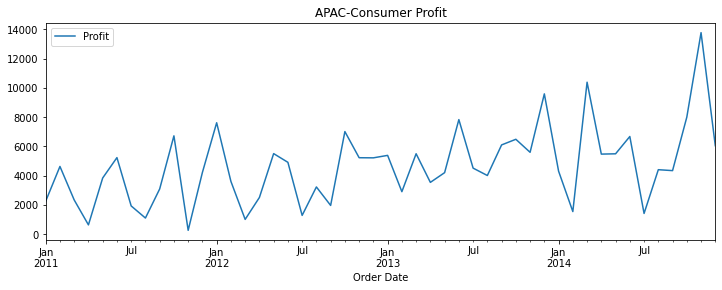

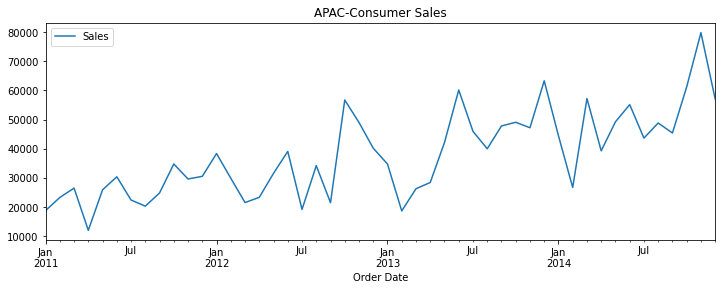

In [ ]:
# Plotting APAC-Consumer's profit 
data3['Profit'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('APAC-Consumer Profit')
plt.show(block=False)

# Plotting APAC-Consumer's sales
data3['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('APAC-Consumer Sales')
plt.show(block=False)

In [ ]:
# Same data as data3 but with timestamp index instead of period index for performing decomposition as the function does not accept period index data

data4 = data3.copy().reset_index()  
data4["Order Date"] = data4["Order Date"].dt.to_timestamp()
data4 = data4.set_index("Order Date")
data4.head()

,Market_Segment,Sales,Profit
Order Date,,,
2011-01-01,APAC-Consumer,18821.9898,2254.4898
2011-02-01,APAC-Consumer,23313.3531,4627.8531
2011-03-01,APAC-Consumer,26518.4919,2337.8319
2011-04-01,APAC-Consumer,12046.0923,633.6423
2011-05-01,APAC-Consumer,25941.9000,3838.9500


## Time series Decomposition

### Additive seasonal decomposition

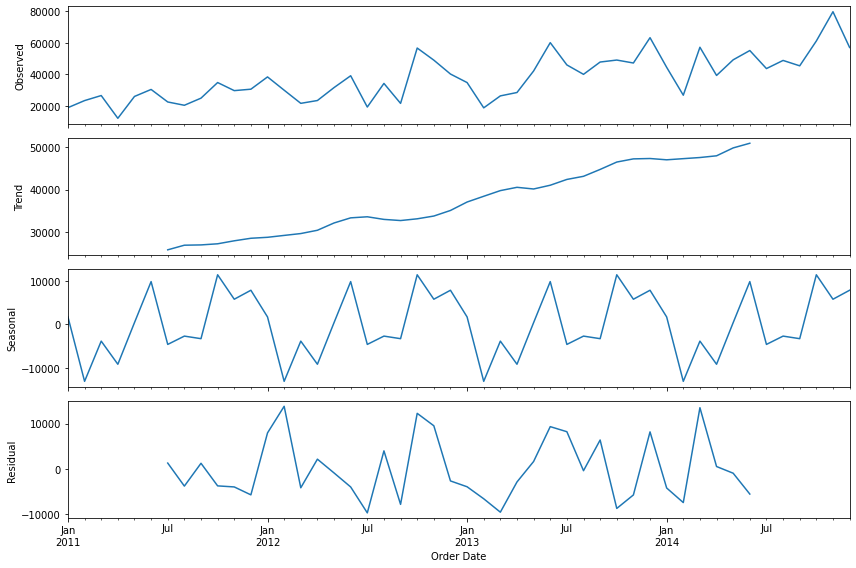

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data4.Sales, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### Multiplicative seasonal decomposition

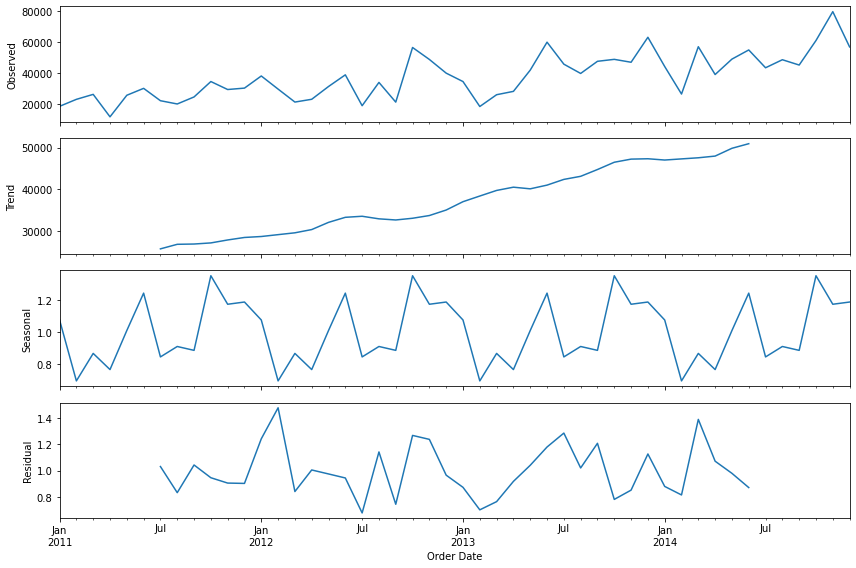

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data4.Sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

In [ ]:
train_len = 42

In [ ]:
# Splitting data into train-test and dropping "Market_Segment" and "Profit" columns from train set and test set

train = data3.drop(["Market_Segment", "Profit"], axis=1)[:train_len]
test = data3.drop(["Market_Segment", "Profit"], axis=1)[train_len:]

## Naive Method

In [ ]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Sales'][train_len-1]
y_hat_naive.head()

,Sales,naive_forecast
Order Date,,
2014-07,43672.0749,55151.4699
2014-08,48848.3409,55151.4699
2014-09,45424.3119,55151.4699
2014-10,61221.9792,55151.4699
2014-11,79834.4295,55151.4699


### Plotting train, test and forecast

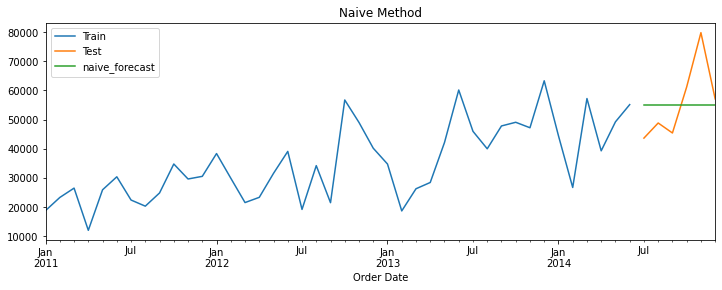

In [ ]:
ax = train.plot(figsize=(12,4), title='Naive Method')
test.plot( ax=ax)
y_hat_naive['naive_forecast'].plot(ax=ax)
ax.legend(['Train','Test','naive_forecast'], loc='best')

### RMSE and MAPE for Naive Method

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_naive['naive_forecast'])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47


## Simple Average Method

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Sales'].mean()
y_hat_avg.head()

,Sales,avg_forecast
Order Date,,
2014-07,43672.0749,35253.632814
2014-08,48848.3409,35253.632814
2014-09,45424.3119,35253.632814
2014-10,61221.9792,35253.632814
2014-11,79834.4295,35253.632814


### Plotting train, test and forecast

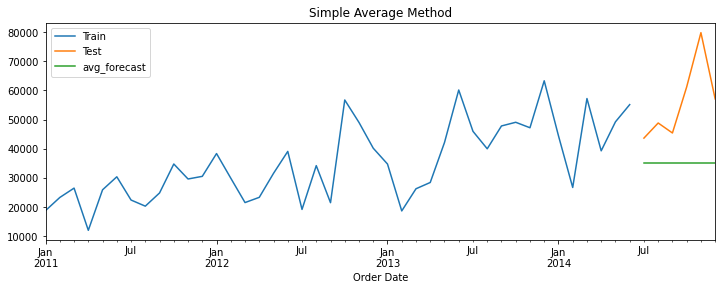

In [ ]:
ax = train.plot(figsize=(12,4), title='Simple Average Method')
test.plot( ax=ax)
y_hat_avg['avg_forecast'].plot(ax=ax)
ax.legend(['Train','Test','avg_forecast'], loc='best')

### RMSE and MAPE for Simple Average Method

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_avg['avg_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34


## Simple Moving Average Method

In [ ]:
y_hat_sma = test.copy()
ma_window = 3
y_hat_sma['sma_forecast'] = train['Sales'].rolling(ma_window).mean()[-1]
y_hat_sma.head()

,Sales,sma_forecast
Order Date,,
2014-07,43672.0749,47902.6745
2014-08,48848.3409,47902.6745
2014-09,45424.3119,47902.6745
2014-10,61221.9792,47902.6745
2014-11,79834.4295,47902.6745


### Plotting train, test and forecast

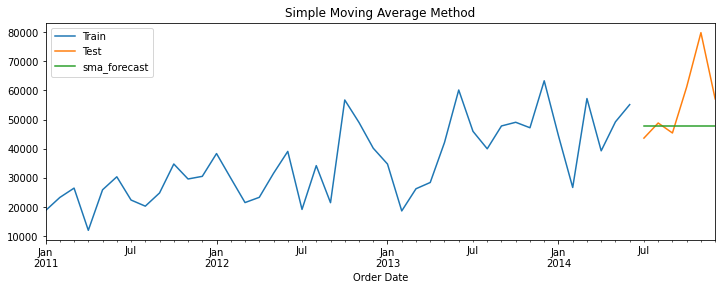

In [ ]:
ax = train.plot(figsize=(12,4), title='Simple Moving Average Method')
test.plot( ax=ax)
y_hat_sma['sma_forecast'].plot(ax=ax)
ax.legend(['Train','Test','sma_forecast'], loc='best')

### RMSE and MAPE for Simple Moving Average Method

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sma['sma_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sma['sma_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82


# Exponential Smoothing Methods:

## Simple Exponential Smoothing Method

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(optimized=True)

y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(6)
model_fit.params

{'damping_slope': nan,
 'initial_level': 22930.320406983166,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': nan,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.22774082175258065,
 'smoothing_seasonal': nan,
 'smoothing_slope': nan,
 'use_boxcox': False}

### Plotting train, test and forecast

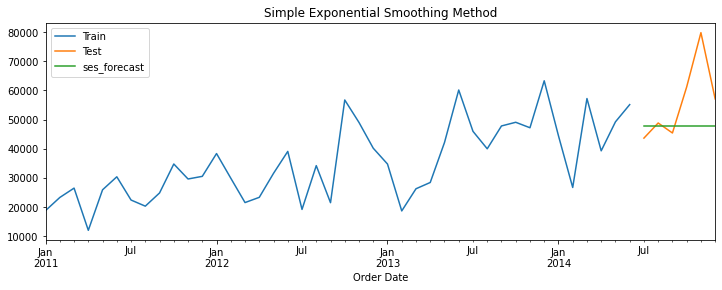

In [ ]:
ax = train.plot(figsize=(12,4), title='Simple Exponential Smoothing Method')
test.plot( ax=ax)
y_hat_ses['ses_forecast'].plot(ax=ax)
ax.legend(['Train','Test','ses_forecast'], loc='best')

### RMSE and MAPE for Exponential Smoothing Method

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14765.07,15.83


## Holt's method with trend

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))
model_fit.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


{'damping_slope': nan,
 'initial_level': 15031.288149897418,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 890.3357714112743,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.0002459432581959583,
 'smoothing_seasonal': nan,
 'smoothing_slope': 0.00024594212583486973,
 'use_boxcox': False}

### Plotting train, test and forecast

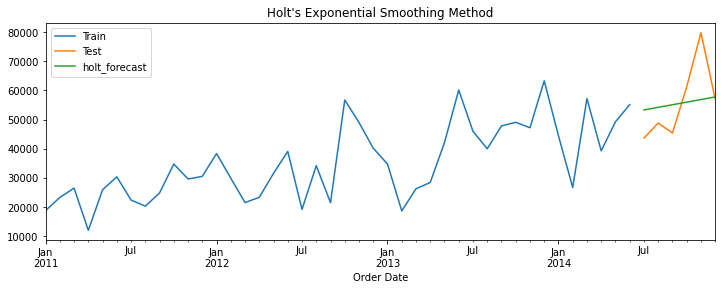

In [ ]:
ax = train.plot(figsize=(12,4), title='Holt\'s Exponential Smoothing Method')
test.plot( ax=ax)
y_hat_holt['holt_forecast'].plot(ax=ax)
ax.legend(['Train','Test','holt_forecast'], loc='best')

### RMSE and MAPE for Holt's Method with trend

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_holt['holt_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14765.07,15.83
0,Holt's exponential smoothing method,11329.05,15.48


## Holt Winters' additive method with trend and seasonality

In [ ]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
y_hat_hwa['hw_forecast'] = model_fit.forecast(6)
model_fit.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


{'damping_slope': nan,
 'initial_level': 29754.133159247503,
 'initial_seasons': array([ -9367.33648305, -19698.59358872, -12159.87124392, -19978.49341582,
         -9285.2527669 ,  -1022.48764768, -14234.73424662, -12930.02858846,
        -13416.65037761,    988.75746148,  -4605.71340929,  -2698.56826195]),
 'initial_slope': 678.2892246996803,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.02634488067960562,
 'smoothing_seasonal': 0.0,
 'smoothing_slope': 0.026341083247216707,
 'use_boxcox': False}

### Plotting train, test and forecast

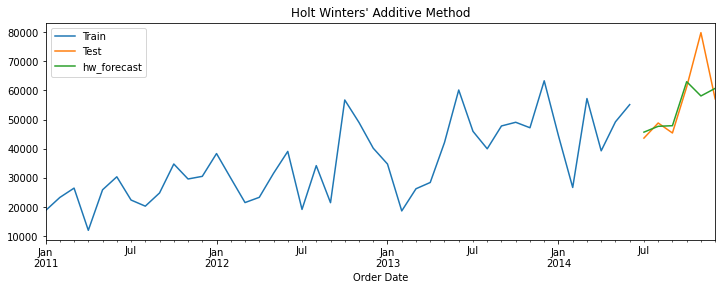

In [ ]:
ax = train.plot(figsize=(12,4), title='Holt Winters\' Additive Method')
test.plot( ax=ax)
y_hat_hwa['hw_forecast'].plot(ax=ax)
ax.legend(['Train','Test','hw_forecast'], loc='best')

### RMSE and MAPE for Holt Winters' additive method with trend and seasonality

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwa['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14765.07,15.83
0,Holt's exponential smoothing method,11329.05,15.48
0,Holt Winters' additive method,9123.45,8.16


## Holt Winter's multiplicative method with trend and seasonality

In [ ]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
y_hat_hwm['hw_forecast'] = model_fit.forecast(6)
model_fit.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


{'damping_slope': nan,
 'initial_level': 34110.96530623723,
 'initial_seasons': array([0.71579961, 0.48469939, 0.6816084 , 0.52920522, 0.73721355,
        0.90142773, 0.62478494, 0.65716939, 0.64918657, 0.93206131,
        0.82799159, 0.88472229]),
 'initial_slope': 730.4170202235896,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.000433357749462941,
 'smoothing_seasonal': 0.0013107033696265584,
 'smoothing_slope': 0.00043335261262144134,
 'use_boxcox': False}

### Plotting train, test and forecast

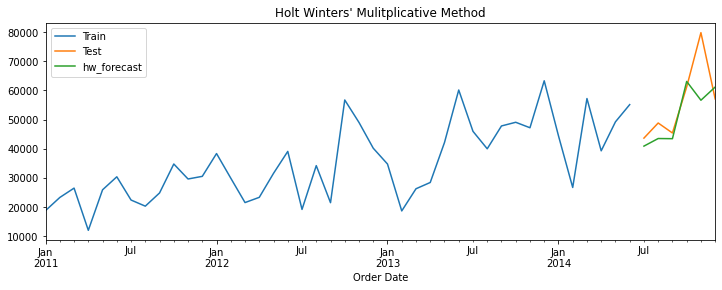

In [ ]:
ax = train.plot(figsize=(12,4), title='Holt Winters\' Mulitplicative Method')
test.plot( ax=ax)
y_hat_hwm['hw_forecast'].plot(ax=ax)
ax.legend(['Train','Test','hw_forecast'], loc='best')

### RMSE and MAPE for Holt Winter's multiplicative method with trend and seasonality

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwm['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14765.07,15.83
0,Holt's exponential smoothing method,11329.05,15.48
0,Holt Winters' additive method,9123.45,8.16
0,Holt Winters' multiplicative method,9974.80,10.12


---

# Auto Regressive methods

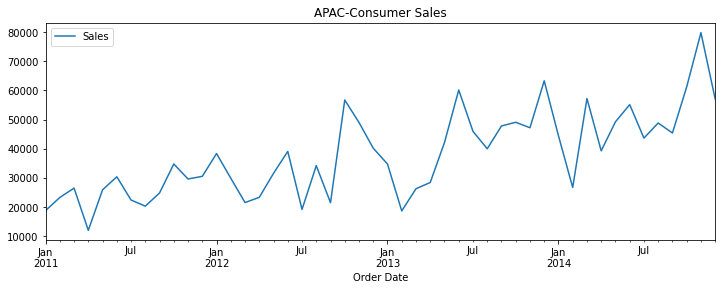

In [ ]:
# Plotting APAC-Consumer's sales
data3['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('APAC-Consumer Sales')
plt.show(block=False)

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data3['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.577076
Critical Values @ 0.05: 0.46
p-value: 0.024720


As per the KPSS test we can se that the data is not stationary. To make the data stationary we can use Box Cox Transformation and Differencing

### Box Cox transformation to make variance constant

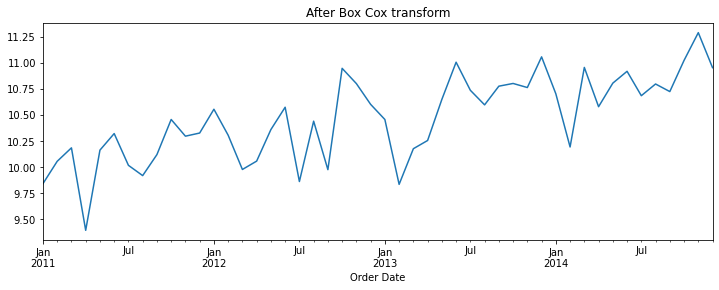

In [ ]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data3['Sales'], lmbda=0), index = data3.index) # lambda = 0 was provided in the problem statement
data_boxcox.plot(figsize=(12,4), title='After Box Cox transform')

### Differencing to remove trend

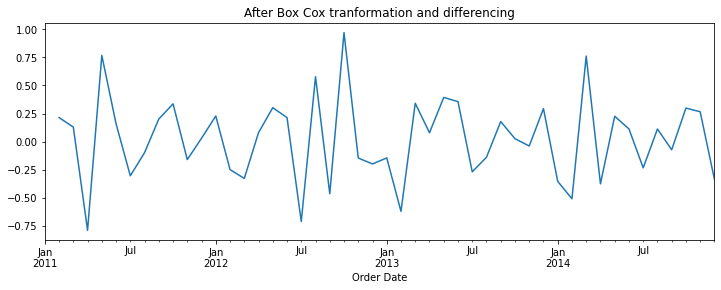

In [ ]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data3.index)
data_boxcox_diff.plot(figsize=(12,4), title='After Box Cox tranformation and differencing')

In [ ]:
data_boxcox_diff.dropna(inplace=True)

### Augmented Dickey-Fuller (ADF) test

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.535011
Critical Values @ 0.05: -2.95
p-value: 0.000170


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [ ]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.156456
Critical Values @ 0.05: 0.46
p-value: 0.100000


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


ADF test and KPSS test above confirm that the data is now stationary

In [ ]:
# Train-Test split
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

## Auto regression method (AR)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.024255
ar.L1.y   -0.406729
dtype: float64


### Recover original time series

In [ ]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plotting train, test and forecast for Auto Regresssion Method

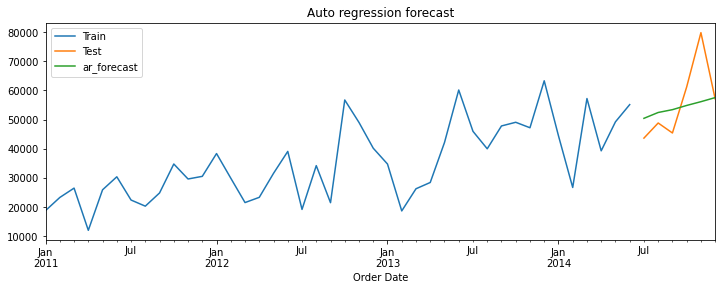

In [ ]:
ax = train.plot(figsize=(12,4), title='Auto regression forecast')
test.plot( ax=ax)
y_hat_ar['ar_forecast'][test.index.min():].plot(ax=ax)
ax.legend(['Train','Test','ar_forecast'], loc='best')

### RMSE and MAPE for Auto Regresssion Method

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14765.07,15.83
0,Holt's exponential smoothing method,11329.05,15.48
0,Holt Winters' additive method,9123.45,8.16
0,Holt Winters' multiplicative method,9974.80,10.12
0,Autoregressive (AR) method,10985.28,13.56


## Moving average method (MA)

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.021415
ma.L1.y   -1.000000
dtype: float64


### Recover original time series

In [ ]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plotting train, test and forecast for Moving Average Method

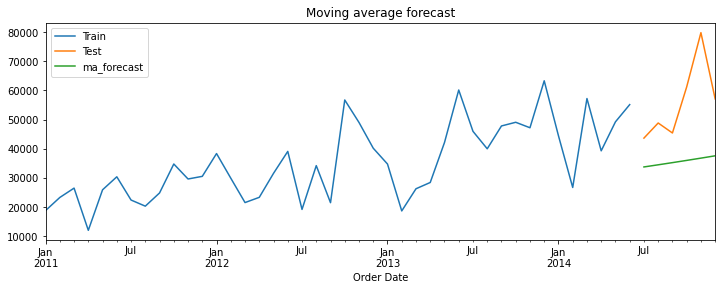

In [ ]:
ax = train.plot(figsize=(12,4), title='Moving average forecast')
test.plot( ax=ax)
y_hat_ma['ma_forecast'][test.index.min():].plot(ax=ax)
ax.legend(['Train','Test','ma_forecast'], loc='best')

### RMSE and MAPE for Moving Average Method

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14765.07,15.83
0,Holt's exponential smoothing method,11329.05,15.48
0,Holt Winters' additive method,9123.45,8.16
0,Holt Winters' multiplicative method,9974.80,10.12
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93


## Auto regression moving average method (ARMA)

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.02147
ar.L1.y    0.07458
ma.L1.y   -1.00000
dtype: float64


### Recover original time series

In [ ]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plotting train, test and forecast for ARMA

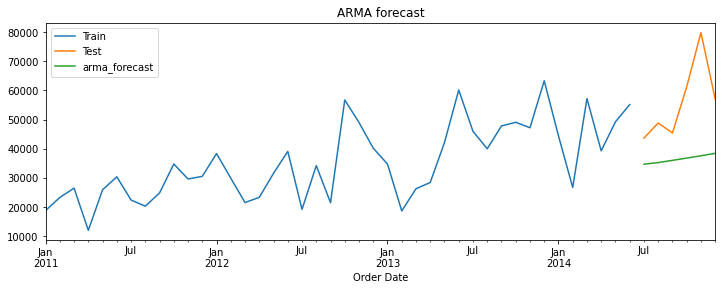

In [ ]:
ax = train.plot(figsize=(12,4), title='ARMA forecast')
test.plot( ax=ax)
y_hat_arma['arma_forecast'][test.index.min():].plot(ax=ax)
ax.legend(['Train','Test','arma_forecast'], loc='best')

### RMSE and MAPE for ARMA Method

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14765.07,15.83
0,Holt's exponential smoothing method,11329.05,15.48
0,Holt Winters' additive method,9123.45,8.16
0,Holt Winters' multiplicative method,9974.80,10.12
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Autoregressive moving average (ARMA) method,22654.32,32.40


## Auto regressive integrated moving average (ARIMA)

In [ ]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.02147
ar.L1.D.y    0.07458
ma.L1.D.y   -1.00000
dtype: float64


### Recover original time series forecast

In [ ]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plotting train, test and forecast for ARIMA

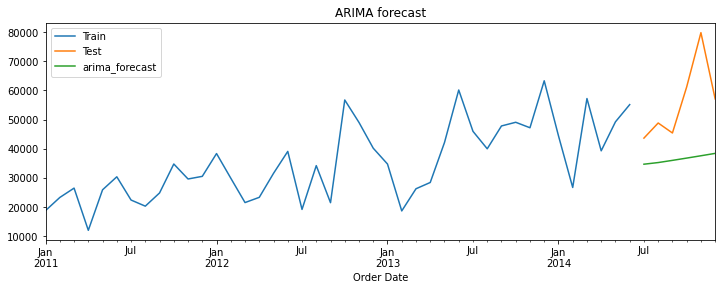

In [ ]:
ax = train.plot(figsize=(12,4), title='ARIMA forecast')
test.plot(ax=ax)
y_hat_arima['arima_forecast'][test.index.min():].plot(ax=ax)
ax.legend(['Train','Test','arima_forecast'], loc='best')

### RMSE and MAPE for ARIMA Method

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14765.07,15.83
0,Holt's exponential smoothing method,11329.05,15.48
0,Holt Winters' additive method,9123.45,8.16
0,Holt Winters' multiplicative method,9974.80,10.12
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Autoregressive moving average (ARMA) method,22654.32,32.40


## Seasonal auto regressive integrated moving average (SARIMA)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1 -0.041414
ma.L1 -0.997150
ar.S.L12 0.098522
ma.S.L12 -0.969133
sigma2 0.058396
dtype: float64

### Recover original time series forecast

In [ ]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plotting train, test and forecast for SARIMA Method

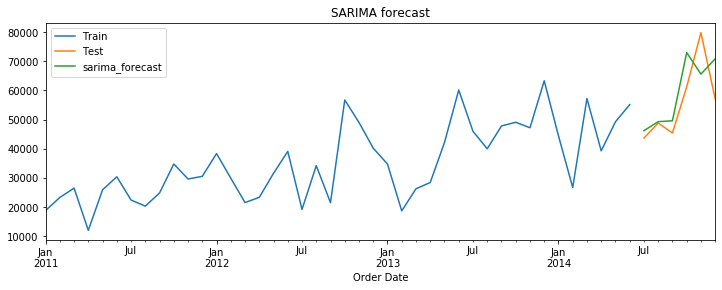

In [ ]:
ax = train.plot(figsize=(12,4), title='SARIMA forecast')
test.plot(ax=ax)
y_hat_sarima['sarima_forecast'][test.index.min():].plot(ax=ax)
ax.legend(['Train','Test','sarima_forecast'], loc='best')

### RMSE and MAPE for SARIMA Method

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14765.07,15.83
0,Holt's exponential smoothing method,11329.05,15.48
0,Holt Winters' additive method,9123.45,8.16
0,Holt Winters' multiplicative method,9974.80,10.12
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Autoregressive moving average (ARMA) method,22654.32,32.40


*   The best forecasting method in the smoothing technique is **Holt Winter’s Additive Method** with the least MAPE value of **8.16%**. Holt Winter’s Additive Method forecast is able to predict the sales closer to the actual values.

*   The best forecasting method in the ARIMA set of techniques is Seasonal Auto Regressive Integrated Moving Average (**SARIMA**) with MAPE value of **12.85%**.




# Fin!